In [1]:
import os
os.environ["CUDA_LAUNCH_BLOCKING"] = "1"

In [2]:
import torch

torch.manual_seed(0)
torch.cuda.manual_seed(0)
torch.cuda.manual_seed_all(0)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

In [3]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split

import torch.nn.functional as F
from torch import nn, optim, Tensor

from torch_geometric.utils import structured_negative_sampling
from torch_geometric.nn.conv.gcn_conv import gcn_norm
from torch_geometric.nn import LGConv

In [4]:
# Load the MovieLens dataset
ratings = pd.read_csv('./dataset/ml-latest-small/ratings.csv')
movies = pd.read_csv('./dataset/ml-latest-small/movies.csv')

# Preprocess the data
ratings = ratings.loc[ratings['movieId'].isin(movies['movieId'])]

In [5]:
ratings

,userId,movieId,rating,timestamp
0,1,1,4.0,964982703
1,1,3,4.0,964981247
2,1,6,4.0,964982224
3,1,47,5.0,964983815
4,1,50,5.0,964982931
...,...,...,...,...
100831,610,166534,4.0,1493848402
100832,610,168248,5.0,1493850091
100833,610,168250,5.0,1494273047
100834,610,168252,5.0,1493846352


In [6]:
# Map user and movie IDs to indices
user_map = {user_id: i for i, user_id in enumerate(ratings['userId'].unique())}
movie_map = {movie_id: i for i, movie_id in enumerate(ratings['movieId'].unique())}

# Count the number of users, movies and total entities in the dataset
num_users = len(user_map)
num_movies = len(movie_map)
num_total = num_users + num_movies

In [7]:
# Create a tensor for user and movie indices based on the user ratings in the dataset
user_ids = torch.LongTensor([user_map[user_id] for user_id in ratings['userId']])
movie_ids = torch.LongTensor([movie_map[movie_id] for movie_id in ratings['movieId']])
edge_index = torch.stack([user_ids, movie_ids])

In [8]:
# Split the dataset into training and test sets
train_index, test_index = train_test_split(range(len(ratings)), test_size=0.2, random_state=0)
val_index, test_index = train_test_split(test_index, test_size=0.5, random_state=0)

In [9]:
train_edge_index = edge_index[:, train_index]
val_edge_index = edge_index[:, val_index]
test_edge_index = edge_index[:, test_index]

In [10]:
# Generate a batch of random indices using np.random.choice
def sample_mini_batch(edge_index):
  index = np.random.choice(range(edge_index.shape[1]), size=BATCH_SIZE)

  # Generate negative samples
  edge_index = structured_negative_sampling(edge_index)
  edge_index = torch.stack(edge_index, dim=0)

  # Select the user, positive and negative samples
  user_index = edge_index[0, index]
  pos_movie_index = edge_index[1, index]
  neg_movie_index = edge_index[2, index]

  return user_index, pos_movie_index, neg_movie_index

In [11]:
# LightGCN Model
class LightGCN(nn.Module):
  def __init__(self, num_users, num_movies, num_layers=4, dim_h=64):
    super().__init__()
    self.num_users = num_users
    self.num_movies = num_movies
    self.num_layers = num_layers
    self.emb_users = nn.Embedding(num_embeddings=self.num_users, embedding_dim=dim_h)
    self.emb_movies = nn.Embedding(num_embeddings=self.num_movies, embedding_dim=dim_h)
    self.convs = nn.ModuleList(LGConv() for _ in range(num_layers))

    # Initialize the weights
    nn.init.normal_(self.emb_users.weight, std=0.01)
    nn.init.normal_(self.emb_movies.weight, std=0.01)

  def forward(self, edge_index):
    emb = torch.cat([self.emb_users.weight, self.emb_movies.weight])
    embs = [emb]
    for conv in self.convs:
      emb = conv(x=emb, edge_index=edge_index)
      embs.append(emb)
    
    emb_final = 1/(self.num_layers+1) * torch.mean(torch.stack(embs, dim=1), dim=1)
    
    emb_users_final, emb_movies_final = torch.split(emb_final, [self.num_users, self.num_movies])

    return emb_users_final, self.emb_users.weight, emb_movies_final, self.emb_movies.weight

In [12]:
# Calculate the loss
def bpr_loss(emb_users_final, emb_users, emb_pos_movies_final, emb_pos_movies, emb_neg_movies_final, emb_neg_movies):
  reg_loss = LAMBDA * (emb_users.norm().pow(2) +
                       emb_pos_movies.norm().pow(2) +
                       emb_neg_movies.norm().pow(2))
  pos_ratings = torch.mul(emb_users_final, emb_pos_movies_final).sum(dim=-1)
  neg_ratings = torch.mul(emb_users_final, emb_neg_movies_final).sum(dim=-1)
  bpr_loss = torch.mean(torch.nn.functional.softplus(pos_ratings - neg_ratings))
  return -bpr_loss + reg_loss

In [13]:
def get_user_movies(edge_index):
  user_movies = dict()
  for i in range(edge_index.shape[1]):
    user = edge_index[0][i].item()
    item = edge_index[1][i].item()
    if user not in user_movies:
      user_movies[user] = []
    user_movies[user].append(item)
  return user_movies

In [14]:
def compute_recall_at_k(items_ground_truth, items_predicted):
  num_correct_pred = np.sum(items_predicted, axis=1)
  num_total_pred = np.array([len(items_ground_truth[i]) for i in range(len(items_ground_truth))])

  recall = np.mean(num_correct_pred / num_total_pred)

  return recall

In [15]:
def compute_ndcg_at_k(items_ground_truth, items_predicted):
  test_matrix = np.zeros((len(items_predicted), K))

  for i, items in enumerate(items_ground_truth):
    length = min(len(items), K)
    test_matrix[i, :length] = 1
  
  max_r = test_matrix
  idcg = np.sum(max_r * 1. / np.log2(np.arange(2, K + 2)), axis=1)
  dcg = items_predicted * (1. / np.log2(np.arange(2, K + 2)))
  dcg = np.sum(dcg, axis=1)
  idcg[idcg == 0.] = 1.
  ndcg = dcg / idcg
  ndcg[np.isnan(ndcg)] = 0.
  
  return np.mean(ndcg)

In [16]:
# wrapper function to get evaluation metrics
def get_metrics(model, edge_index, exclude_edge_indices):

  ratings = torch.matmul(model.emb_users.weight, model.emb_movies.weight.T)

  for exclude_edge_index in exclude_edge_indices:
    user_pos_movies = get_user_movies(exclude_edge_index)
    exclude_users = []
    exclude_movies = []
    for user, items in user_pos_movies.items():
      exclude_users.extend([user] * len(items))
      exclude_movies.extend(items)
    ratings[exclude_users, exclude_movies] = -1024

  # get the top k recommended items for each user
  _, top_K_movies = torch.topk(ratings, k=K)

  # get all unique users in evaluated split
  users = edge_index[0].unique()

  test_user_pos_movies = get_user_movies(edge_index)

  # convert test user pos items dictionary into a list
  test_user_pos_movies_list = [test_user_pos_movies[user.item()] for user in users]

  # determine the correctness of topk predictions
  items_predicted = []
  for user in users:
    ground_truth_movies = test_user_pos_movies[user.item()]
    label = list(map(lambda x: x in ground_truth_movies, top_K_movies[user]))
    items_predicted.append(label)

  recall = compute_recall_at_k(test_user_pos_movies_list, items_predicted)
  ndcg = compute_ndcg_at_k(test_user_pos_movies_list, items_predicted)

  return recall, ndcg

In [17]:
# wrapper function to evaluate model
def test(model, edge_index, exclude_edge_indices):
  emb_users_final, emb_users, emb_movies_final, emb_movies = model.forward(edge_index)
  user_indices, pos_movie_indices, neg_movie_indices = structured_negative_sampling(edge_index, contains_neg_self_loops=False)

  emb_users_final, emb_users = emb_users_final[user_indices], emb_users[user_indices]
  emb_pos_movies_final, emb_pos_movies = emb_movies_final[pos_movie_indices], emb_movies[pos_movie_indices]
  emb_neg_movies_final, emb_neg_movies = emb_movies_final[neg_movie_indices], emb_movies[neg_movie_indices]

  loss = bpr_loss(emb_users_final, emb_users, emb_pos_movies_final, emb_pos_movies, emb_neg_movies_final, emb_neg_movies).item()

  recall, ndcg = get_metrics(model, edge_index, exclude_edge_indices)

  return loss, recall, ndcg

## Training Model

In [18]:
K = 20
LAMBDA = 1e-6
BATCH_SIZE = 1024

In [19]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# device = torch.device('cpu')
model = LightGCN(num_users, num_movies)
model = model.to(device)
edge_index = edge_index.to(device)
train_edge_index = train_edge_index.to(device)
val_edge_index = val_edge_index.to(device)

# optimizer = optim.Adam(model.parameters(), lr=0.001)
optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-5)

In [20]:
num_batch = int(len(train_index) / BATCH_SIZE)
for epoch in range(1, 31):
  model.train()
  for batch in range(num_batch):
    optimizer.zero_grad()

    emb_users_final, emb_users, emb_movies_final, emb_movies = model.forward(train_edge_index)
    
    user_index, pos_movies_index, neg_movies_index = sample_mini_batch(train_edge_index)
    
    emb_users_final, emb_users = emb_users_final[user_index], emb_users[user_index]
    emb_pos_movies_final, emb_pos_movies = emb_movies_final[pos_movies_index], emb_movies_final[pos_movies_index]
    emb_neg_movies_final, emb_neg_movies = emb_movies_final[neg_movies_index], emb_movies_final[neg_movies_index]

    train_loss = bpr_loss(emb_users_final, emb_users, emb_pos_movies_final, emb_pos_movies, emb_neg_movies_final, emb_neg_movies)
    
    train_loss.backward()
    optimizer.step()
    
  if epoch % 5 == 0:
    model.eval()
    val_loss, recall, ndcg = test(model, val_edge_index, [train_edge_index])
    if 'train_data' in globals():
      new_data = pd.DataFrame({
        'epoch': [epoch],
        'train_loss': [train_loss.item()],
        'val_loss': [val_loss],
        'recall': [recall],
        'ndcg': [ndcg]
      })
      train_data = pd.concat([train_data, new_data], ignore_index=True)
    else:
      train_data = pd.DataFrame({
        'epoch': [epoch],
        'train_loss': [train_loss.item()],
        'val_loss': [val_loss],
        'recall': [recall],
        'ndcg': [ndcg]
      })
    print(f"Epoch {epoch} | Train loss: {train_loss.item():.5f} | Val loss: {val_loss:.5f} | Val recall@{K}:{recall:.5f} | Val ndcg@{K}: {ndcg:.5f}")

Epoch 5 | Train loss: -1.01426 | Val loss: -0.53922 | Val recall@20:0.10869 | Val ndcg@20: 0.11297
Epoch 10 | Train loss: -2.81058 | Val loss: -0.23942 | Val recall@20:0.11284 | Val ndcg@20: 0.11502
Epoch 15 | Train loss: -5.88770 | Val loss: 0.01543 | Val recall@20:0.11249 | Val ndcg@20: 0.11516
Epoch 20 | Train loss: -9.82837 | Val loss: 0.26748 | Val recall@20:0.11137 | Val ndcg@20: 0.11437
Epoch 25 | Train loss: -13.53129 | Val loss: 0.47547 | Val recall@20:0.11155 | Val ndcg@20: 0.11372
Epoch 30 | Train loss: -19.54178 | Val loss: 0.78495 | Val recall@20:0.11218 | Val ndcg@20: 0.11460


In [21]:
train_data

,epoch,train_loss,val_loss,recall,ndcg
0,5,-1.014264,-0.539216,0.108687,0.112972
1,10,-2.810579,-0.239416,0.112841,0.115023
2,15,-5.887701,0.015430,0.112490,0.115164
3,20,-9.828368,0.267477,0.111374,0.114369
4,25,-13.531294,0.475471,0.111546,0.113724
5,30,-19.541777,0.784954,0.112179,0.114604


In [30]:
train_data.to_csv('./training/train_data.csv', index=False)

In [22]:
test_loss, test_recall, test_ndcg = test(model, test_edge_index.to(device), [train_edge_index, val_edge_index])
print(f"Test loss: {test_loss:.5f} | Test recall@{K}:{test_recall:.5f} | Test ndcg@{K}: {test_ndcg:.5f}")

Test loss: 2.65954 | Test recall@20:0.12069 | Test ndcg@20: 0.12587


In [23]:
movies_df = pd.read_csv('./dataset/ml-latest-small/movies.csv')
ratings_df = pd.read_csv('./dataset/ml-latest-small/ratings.csv')

In [24]:
movieid_title = pd.Series(movies_df['title'].values, index=movies_df['movieId']).to_dict()
movieid_genres = pd.Series(movies_df['genres'].values, index=movies_df['movieId']).to_dict()

In [25]:
user_pos_movies = get_user_movies(edge_index)

In [26]:
user_with_fewest_likes = min(user_pos_movies, key=lambda user: len(user_pos_movies[user]))
fewest_likes_count = len(user_pos_movies[user_with_fewest_likes])

print(f"User {user_with_fewest_likes} liked the fewest movies: {fewest_likes_count} movies.")

User 52 liked the fewest movies: 20 movies.


In [27]:
from PIL import Image
import requests
import matplotlib.pyplot as plt
import matplotlib

# Đặt font hỗ trợ Unicode
matplotlib.rcParams['font.family'] = 'DejaVu Sans'

def recommend(user_id, num_recs):
  # user_id = str(user_id)
  user = user_map[user_id]
  emb_user = model.emb_users.weight[user]
  ratings = model.emb_movies.weight @ emb_user

  values, indices = torch.topk(ratings, k=100)
  
  # Các phim đã được người dùng đánh giá
  # ids = [index.cpu().item() for index in indices if index in user_pos_movies[user]][:num_recs]
  ids = [index.cpu().item() for index in indices if index in user_pos_movies[user]]
  movieids = [list(movie_map.keys())[list(movie_map.values()).index(movie)] for movie in ids]
  titles = [movieid_title[id] for id in movieids]
  genres = [movieid_genres[id] for id in movieids]

  print(f'Phim đã được người dùng {user_id} đánh giá:')
  for i in range(len(movieids)):
    print(f'- {titles[i]}, thể loại: {genres[i]}')

  ids = [index.cpu().item() for index in indices if index not in user_pos_movies[user]][:num_recs]
  movieids = [list(movie_map.keys())[list(movie_map.values()).index(book)] for book in ids]
  titles = [movieid_title[id] for id in movieids]
  genres = [movieid_genres[id] for id in movieids]

  print(f'\nPhim được đề xuất cho người dùng {user_id}')
  for i in range(num_recs):
    print(f'- {titles[i]}, by {genres[i]}')
  
  headers = {'User-Agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/58.0.3029.110 Safari/537.3'}
  fig, axs = plt.subplots(1, num_recs, figsize=(20,6))
  fig.patch.set_alpha(0)
  poster_urls = pd.read_csv('./dataset/ml-latest-small/poster_urls.csv')
  poster_urls_dict = pd.Series(poster_urls['poster_url'].values, index=poster_urls['movieId']).to_dict()
  for i, movieid in enumerate(movieids):
    url = poster_urls_dict[movieid]
    img = Image.open(requests.get(url, stream=True, headers=headers).raw)
    rating = ratings_df.loc[ratings_df['movieId'] == movieid, 'rating'].values.mean()
    axs[i].axis('off')
    axs[i].imshow(img)
    axs[i].set_title(f'{rating:.1f} / 5 ★', y=-0.1, fontsize=18)

Phim đã được người dùng 52 đánh giá:
- Forrest Gump (1994), thể loại: Comedy|Drama|Romance|War
- Shawshank Redemption, The (1994), thể loại: Crime|Drama
- Matrix, The (1999), thể loại: Action|Sci-Fi|Thriller
- Star Wars: Episode IV - A New Hope (1977), thể loại: Action|Adventure|Sci-Fi
- Fight Club (1999), thể loại: Action|Crime|Drama|Thriller
- Apollo 13 (1995), thể loại: Adventure|Drama|IMAX
- Raiders of the Lost Ark (Indiana Jones and the Raiders of the Lost Ark) (1981), thể loại: Action|Adventure
- Lion King, The (1994), thể loại: Adventure|Animation|Children|Drama|Musical|IMAX
- Star Wars: Episode VI - Return of the Jedi (1983), thể loại: Action|Adventure|Sci-Fi
- Star Wars: Episode V - The Empire Strikes Back (1980), thể loại: Action|Adventure|Sci-Fi
- Aladdin (1992), thể loại: Adventure|Animation|Children|Comedy|Musical
- Léon: The Professional (a.k.a. The Professional) (Léon) (1994), thể loại: Action|Crime|Drama|Thriller
- Dark Knight, The (2008), thể loại: Action|Crime|Drama|I

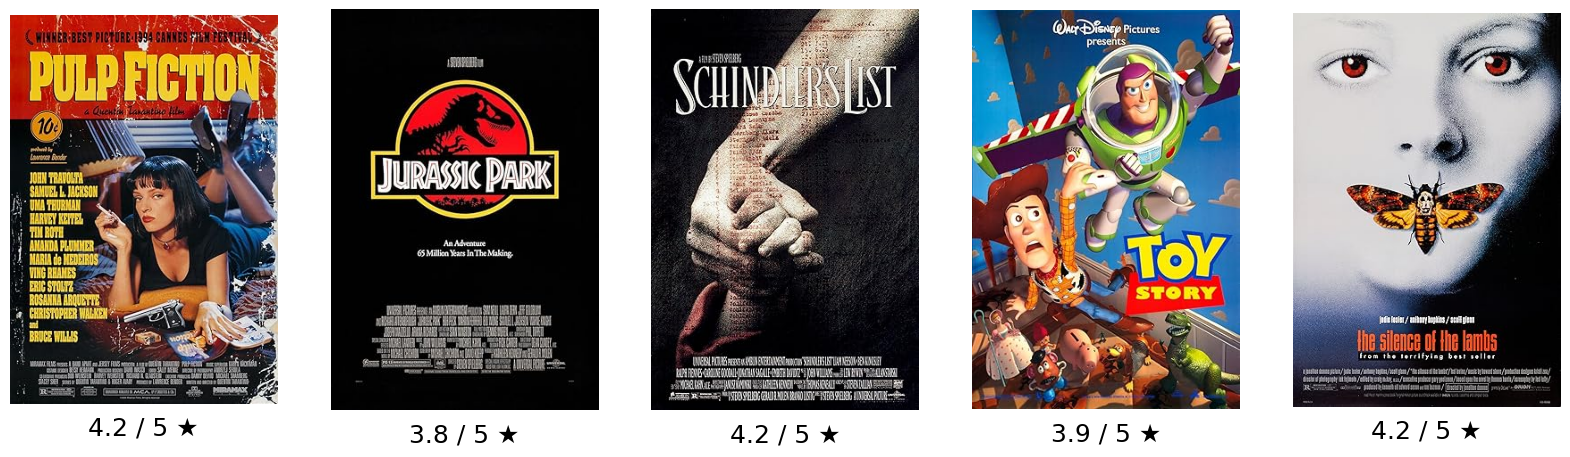

In [28]:
recommend(52, 5)